In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler 

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Criação das funções para viabilizar a aplicação do modelo:

#### Função para instanciar o modelo:

In [2]:
from sklearn.neighbors import KNeighborsClassifier

def instantiate_KNN_model (X_train, y_train):
    k_range = range(1, 31)
    param_grid = {"n_neighbors": k_range}
    #scores = ['accuracy','f1','precision','recall','roc_auc']

    #Init classifier
    knn = KNeighborsClassifier()

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(knn, param_grid, n_jobs = -1, cv=5, scoring = 'roc_auc')
    #grid_cv = GridSearchCV(knn, param_grid, n_jobs = -1, cv=cv, scoring = scores, refit='accuracy')

    # Fit 
    grid_cv.fit(X_train, y_train)

    #mean_test_score = grid_cv.cv_results_['mean_test_score']
    #std_test_score = grid_cv.cv_results_['std_test_score']
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return best_score, best_params

#### Criação de uma função para predição do classificador final:

In [3]:
from sklearn.neighbors import KNeighborsClassifier

def create_final_cl(X_over, y_over, X_test, y_test, n_neighbors):

    # parametrizando o modelo final
    final_cl = KNeighborsClassifier(n_neighbors=n_neighbors)

    #treinando o modelo final
    final_cl.fit(X_over, y_over)
    preds = final_cl.predict(X_test)
    accuracy_score(y_test, preds)

    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)

    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('Macro: ', f1_score(y_test, preds, average='macro'))
    print('Micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('Macro: ', precision_score(y_test, preds, average='macro'))
    print('Micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))

    return preds, final_cl

#### Criação de funções para plotagem de métricas:

In [4]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_permutation_importance(final_cl, X_test, y_test):
    perm_importance = permutation_importance(final_cl, X_test, y_test)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.figure(figsize=(10,10))
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], height=0.8)
    plt.xlabel("Permutation Importance")
    plt.show()

#### Criação de uma função para aplicar o modelo para o período de tempo escolhido:

In [5]:
def apply_periodos (d, df):
    for i in range (0,838,30):
    
        #treino!
        data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
        data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
        data_fim = data_inicio + pd.Timedelta(days = d)
        
        treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
        X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
        y_train = treino['death']

        #teste!
        teste = df[(df['data_notificacao'] >= data_fim_treino) & (df['data_notificacao'] <= data_fim )]
        X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
        y_test = teste['death']

        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(X_train, y_train)

        print('Início do período: ', data_inicio)
        print('Final do período: ', data_fim)

        ####################################################
        #              APLICANDO O MODELO                  #
        ####################################################

        list_random_states = [42]
        #list_random_states = [0,12,42,50,54,68,79,81,92,112]

        mean_test_scores = []
        std_test_scores = []
        best_scores = []
        best_params = []

        for random_state in list_random_states:

            mean_test_score, std_test_score, best_score, best_param = instantiate_KNN_model(X_over, y_over)

            mean_test_scores.append(mean_test_score)
            std_test_scores.append(std_test_score)
            best_scores.append(best_score)
            best_params.append(best_param)

        idx = best_scores.index(max(best_scores))
        best_param = best_params[idx]
        
        preds, final_cl = create_final_cl(X_over, y_over, X_test, y_test, best_param['n_neighbors'])
        
        plot_conf_matrix (X_test, y_test, preds, final_cl)

        plot_roc_curve(y_test, preds)

        plot_permutation_importance(final_cl, X_test, y_test)


## Lendo o dataset:

In [6]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

### Utilizando a class de pré-processamento para preparar o dataset:

In [7]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']
features = np.array(list_features)

In [8]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_57320\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.356522,0,1,2020-02-26
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-26
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.217391,1,0,2020-02-27
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-27
4,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.260870,1,0,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-12
36431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,0,1,2022-06-12
36432,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2022-06-12
36433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-13


### Aplicação do modelo considerando períodos de 90 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-05-26 00:00:00
########################################

best_score: 0.9148544001329144
best_params_: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.7482673820701989
########################################
"""Métricas f1_score:"""
f1:  0.5981441827266237
Macro:  0.7074379767799786
Micro:  0.7482673820701988
weighted:  0.7667640067289045
########################################
"""Métricas precision_score:"""
Precision:  0.4709187974150042
Macro:  0.7012102804598689
Micro:  0.7482673820701989
weighted:  0.8262153600111614


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


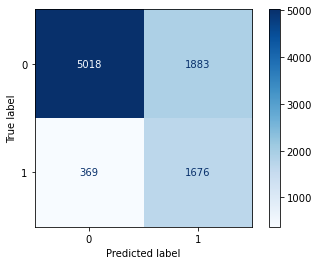

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      6901
           1       0.47      0.82      0.60      2045

    accuracy                           0.75      8946
   macro avg       0.70      0.77      0.71      8946
weighted avg       0.83      0.75      0.77      8946

roc_auc_score:  0.7733504481296605


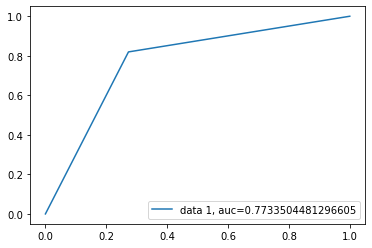

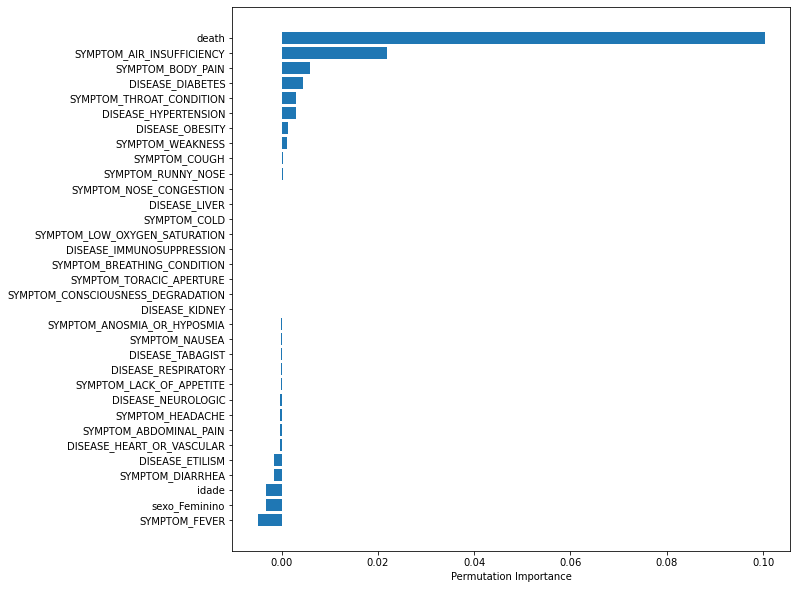

Início do período:  2020-03-27 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.9000584229412647
best_params_: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.66417194396469
########################################
"""Métricas f1_score:"""
f1:  0.5742092457420924
Macro:  0.6484797812994365
Micro:  0.66417194396469
weighted:  0.6832989941888229
########################################
"""Métricas precision_score:"""
Precision:  0.4328686720469552
Macro:  0.6753880583574816
Micro:  0.66417194396469
weighted:  0.7890850187790162


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


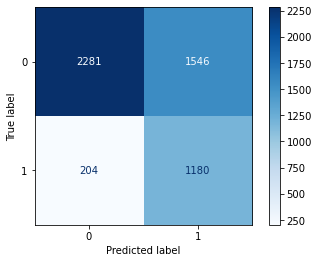

              precision    recall  f1-score   support

           0       0.92      0.60      0.72      3827
           1       0.43      0.85      0.57      1384

    accuracy                           0.66      5211
   macro avg       0.68      0.72      0.65      5211
weighted avg       0.79      0.66      0.68      5211

roc_auc_score:  0.7243146883038224


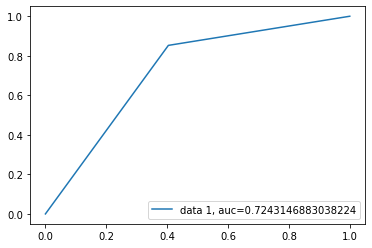

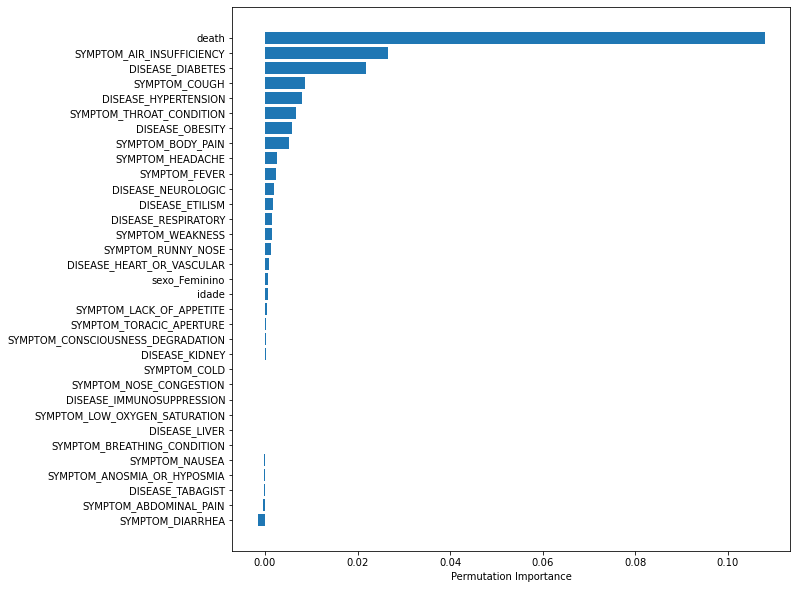

Início do período:  2020-04-26 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.8337643067873254
best_params_: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6557126480703095
########################################
"""Métricas f1_score:"""
f1:  0.48777714610574197
Macro:  0.6142482852830868
Micro:  0.6557126480703095
weighted:  0.6861101820949751
########################################
"""Métricas precision_score:"""
Precision:  0.3592964824120603
Macro:  0.6318618743753907
Micro:  0.6557126480703095
weighted:  0.786735675617069


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


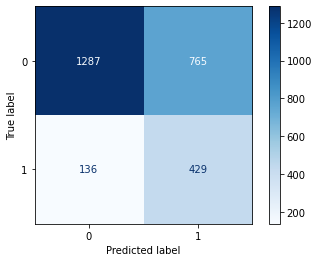

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      2052
           1       0.36      0.76      0.49       565

    accuracy                           0.66      2617
   macro avg       0.63      0.69      0.61      2617
weighted avg       0.79      0.66      0.69      2617

roc_auc_score:  0.6932425089271852


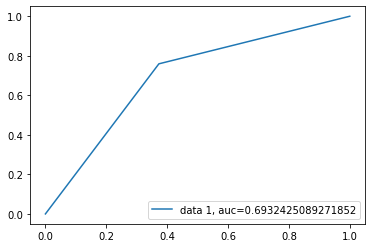

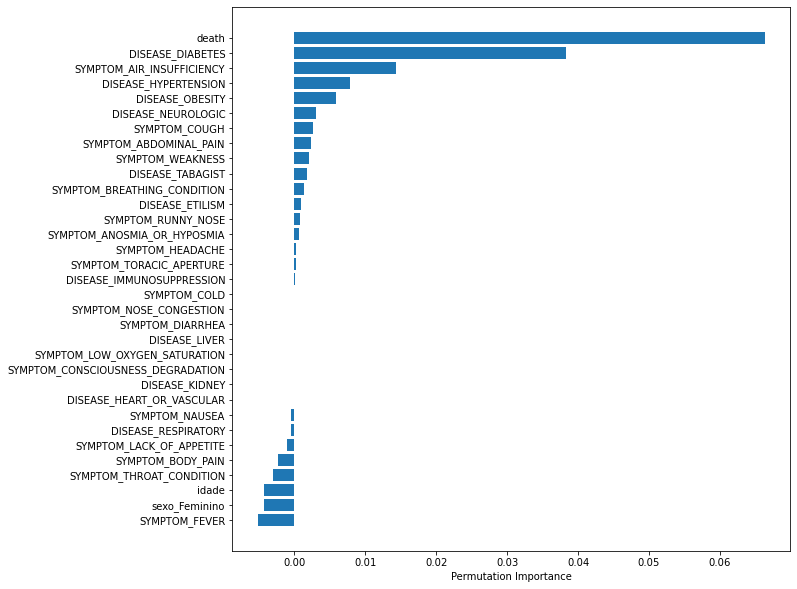

Início do período:  2020-05-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.814427775428004
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.7023319615912208
########################################
"""Métricas f1_score:"""
f1:  0.42744063324538256
Macro:  0.6131642461871027
Micro:  0.7023319615912208
weighted:  0.7280632166078378
########################################
"""Métricas precision_score:"""
Precision:  0.3375
Macro:  0.6094452965235173
Micro:  0.7023319615912208
weighted:  0.7776858023288759


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


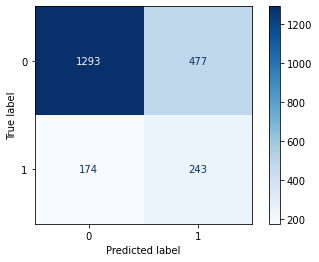

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1770
           1       0.34      0.58      0.43       417

    accuracy                           0.70      2187
   macro avg       0.61      0.66      0.61      2187
weighted avg       0.78      0.70      0.73      2187

roc_auc_score:  0.6566211437629557


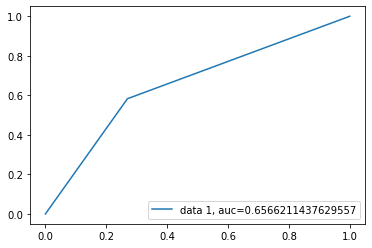

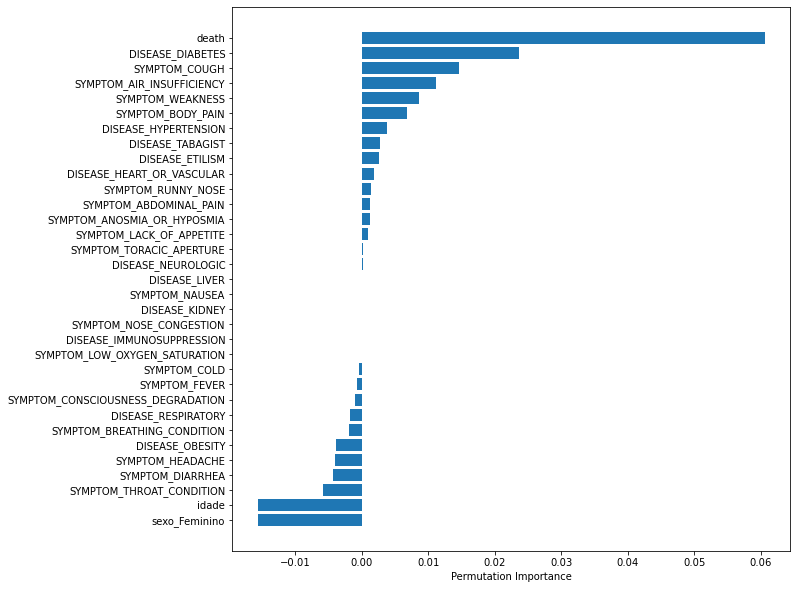

Início do período:  2020-06-25 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.8612622349065415
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6756756756756757
########################################
"""Métricas f1_score:"""
f1:  0.37007874015748027
Macro:  0.5758491971942998
Micro:  0.6756756756756757
weighted:  0.7051509033052742
########################################
"""Métricas precision_score:"""
Precision:  0.28952772073921973
Macro:  0.5772915542266088
Micro:  0.6756756756756757
weighted:  0.7581161252693602


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


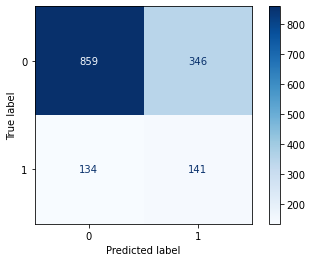

              precision    recall  f1-score   support

           0       0.87      0.71      0.78      1205
           1       0.29      0.51      0.37       275

    accuracy                           0.68      1480
   macro avg       0.58      0.61      0.58      1480
weighted avg       0.76      0.68      0.71      1480

roc_auc_score:  0.612795171633346


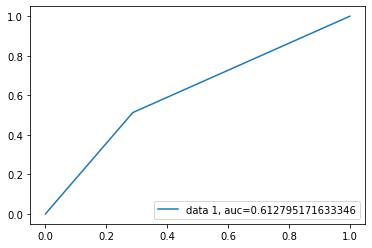

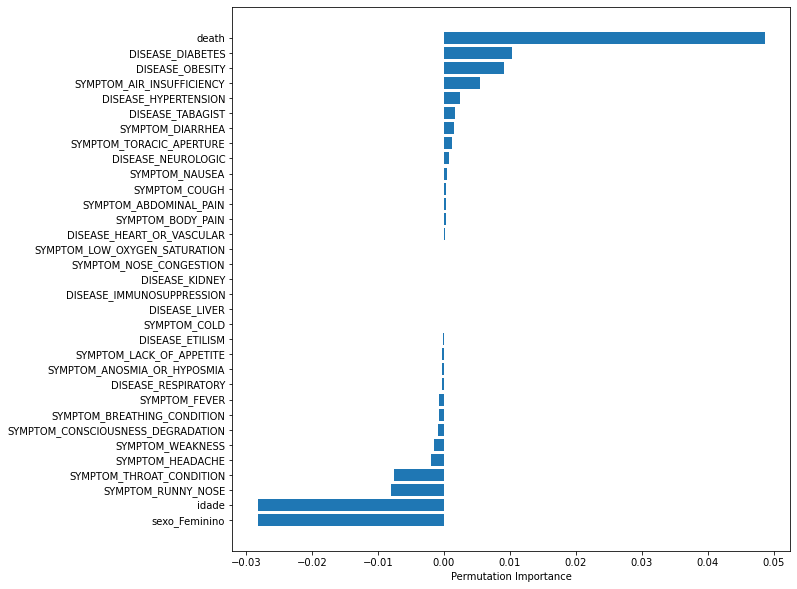

Início do período:  2020-07-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.8871850295605043
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6448243114909782
########################################
"""Métricas f1_score:"""
f1:  0.42813455657492355
Macro:  0.5852793994995831
Micro:  0.6448243114909782
weighted:  0.6678065582244992
########################################
"""Métricas precision_score:"""
Precision:  0.3465346534653465
Macro:  0.5885215640208088
Micro:  0.6448243114909782
weighted:  0.7156049083106195


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


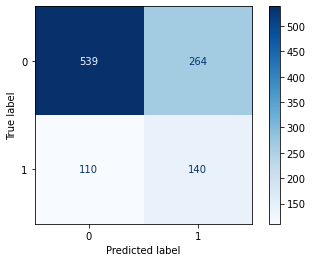

              precision    recall  f1-score   support

           0       0.83      0.67      0.74       803
           1       0.35      0.56      0.43       250

    accuracy                           0.64      1053
   macro avg       0.59      0.62      0.59      1053
weighted avg       0.72      0.64      0.67      1053

roc_auc_score:  0.6156164383561644


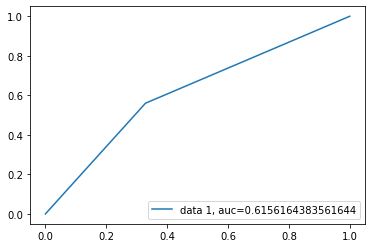

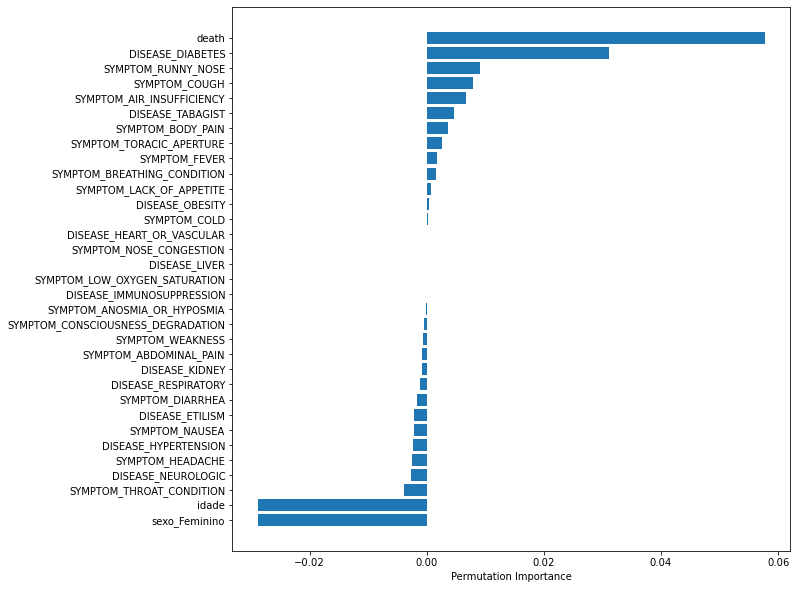

Início do período:  2020-08-24 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.8784343203844399
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6559714795008913
########################################
"""Métricas f1_score:"""
f1:  0.4079754601226994
Macro:  0.5827565742824553
Micro:  0.6559714795008913
weighted:  0.656906137865382
########################################
"""Métricas precision_score:"""
Precision:  0.40425531914893614
Macro:  0.5823294250221351
Micro:  0.6559714795008913
weighted:  0.6578760153925832


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


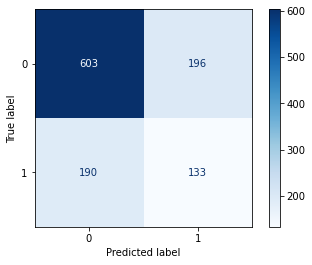

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       799
           1       0.40      0.41      0.41       323

    accuracy                           0.66      1122
   macro avg       0.58      0.58      0.58      1122
weighted avg       0.66      0.66      0.66      1122

roc_auc_score:  0.5832290362953692


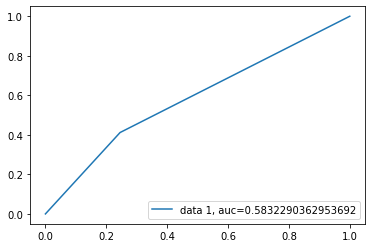

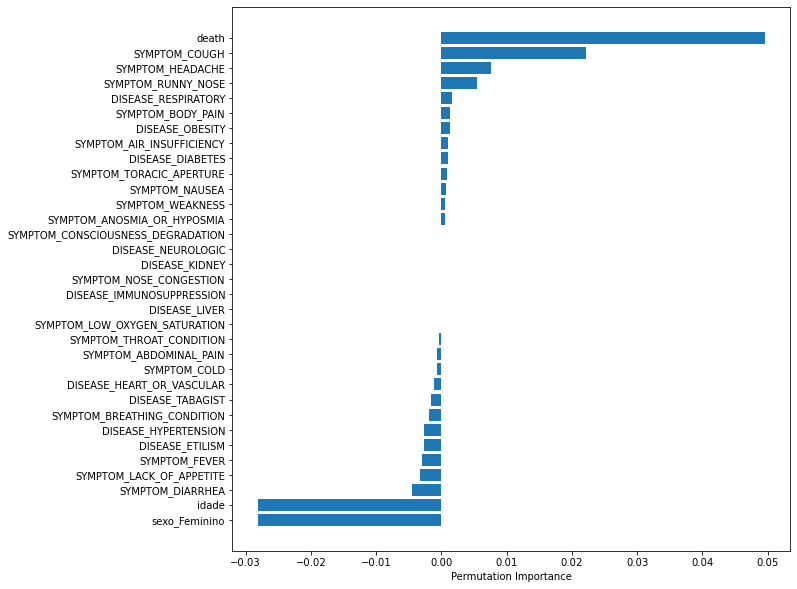

Início do período:  2020-09-23 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.8384133781576286
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.678030303030303
########################################
"""Métricas f1_score:"""
f1:  0.4835965978128798
Macro:  0.6248472807446347
Micro:  0.678030303030303
weighted:  0.6715028093493658
########################################
"""Métricas precision_score:"""
Precision:  0.5223097112860893
Macro:  0.6317618843970383
Micro:  0.678030303030303
weighted:  0.6679142688488365


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


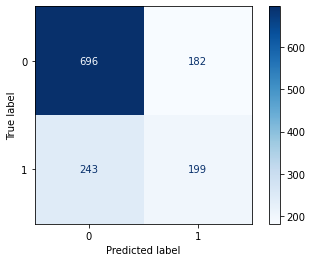

              precision    recall  f1-score   support

           0       0.74      0.79      0.77       878
           1       0.52      0.45      0.48       442

    accuracy                           0.68      1320
   macro avg       0.63      0.62      0.62      1320
weighted avg       0.67      0.68      0.67      1320

roc_auc_score:  0.6214684752471165


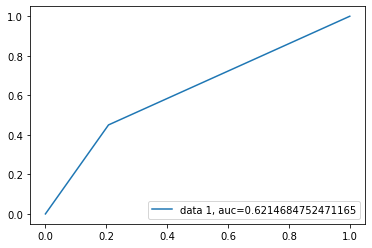

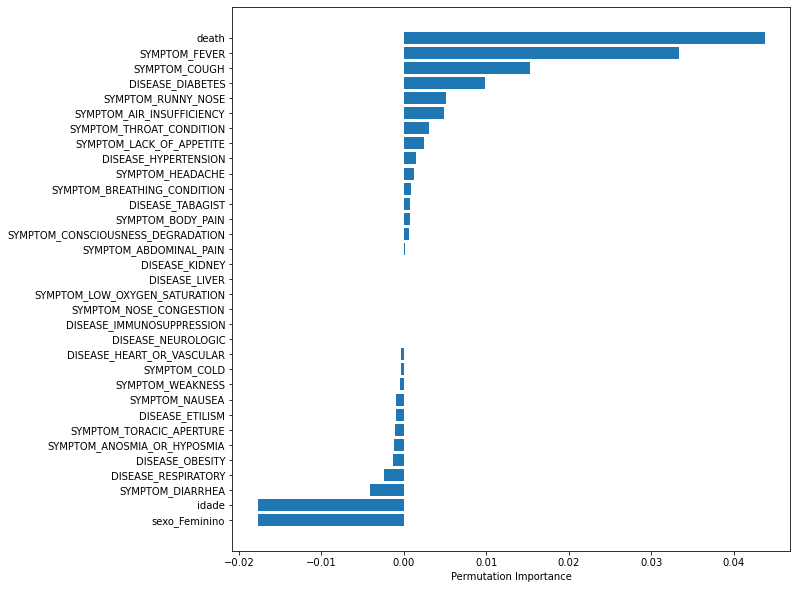

Início do período:  2020-10-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.8569076508808651
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6811497326203209
########################################
"""Métricas f1_score:"""
f1:  0.5461465271170314
Macro:  0.6501984567578974
Micro:  0.6811497326203209
weighted:  0.6823321409116944
########################################
"""Métricas precision_score:"""
Precision:  0.5374531835205992
Macro:  0.6491839722176801
Micro:  0.6811497326203209
weighted:  0.6836890687270727


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


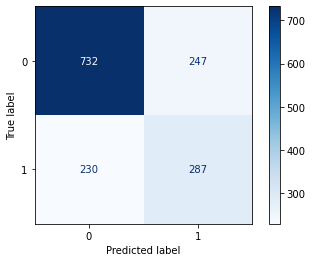

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       979
           1       0.54      0.56      0.55       517

    accuracy                           0.68      1496
   macro avg       0.65      0.65      0.65      1496
weighted avg       0.68      0.68      0.68      1496

roc_auc_score:  0.6514137309021364


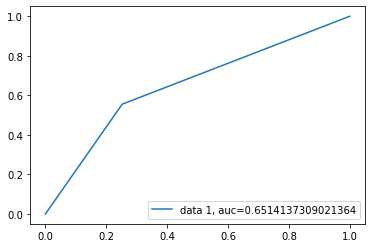

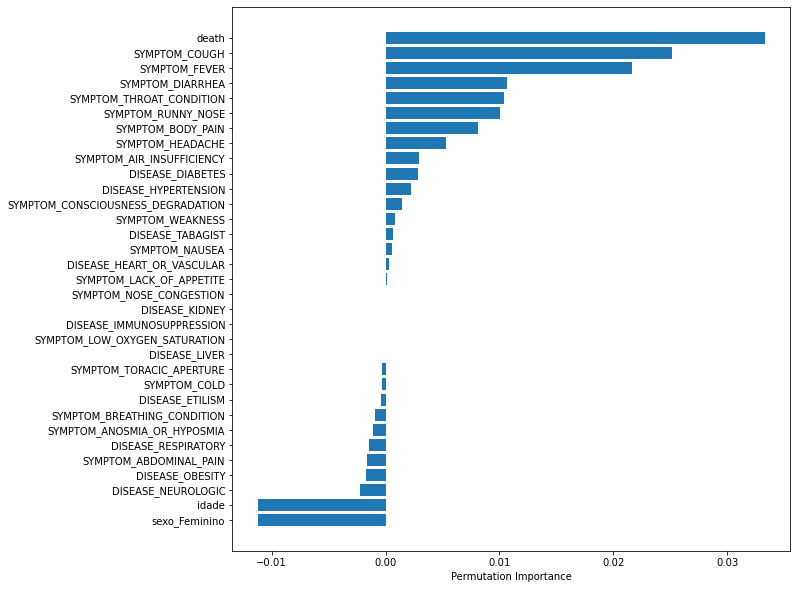

Início do período:  2020-11-22 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.8359069979961209
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6878808395396073
########################################
"""Métricas f1_score:"""
f1:  0.563859981078524
Macro:  0.660422346891397
Micro:  0.6878808395396073
weighted:  0.6922611228906312
########################################
"""Métricas precision_score:"""
Precision:  0.5302491103202847
Macro:  0.6574742819360986
Micro:  0.6878808395396073
weighted:  0.6994232721709676


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


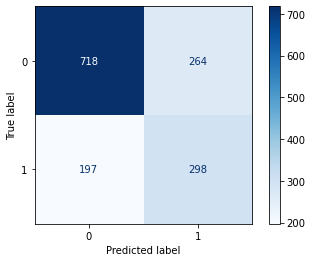

              precision    recall  f1-score   support

           0       0.78      0.73      0.76       982
           1       0.53      0.60      0.56       495

    accuracy                           0.69      1477
   macro avg       0.66      0.67      0.66      1477
weighted avg       0.70      0.69      0.69      1477

roc_auc_score:  0.666590549075274


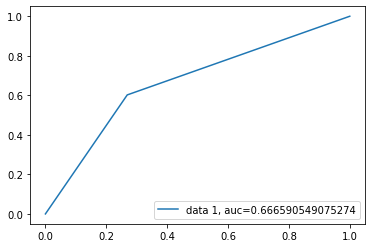

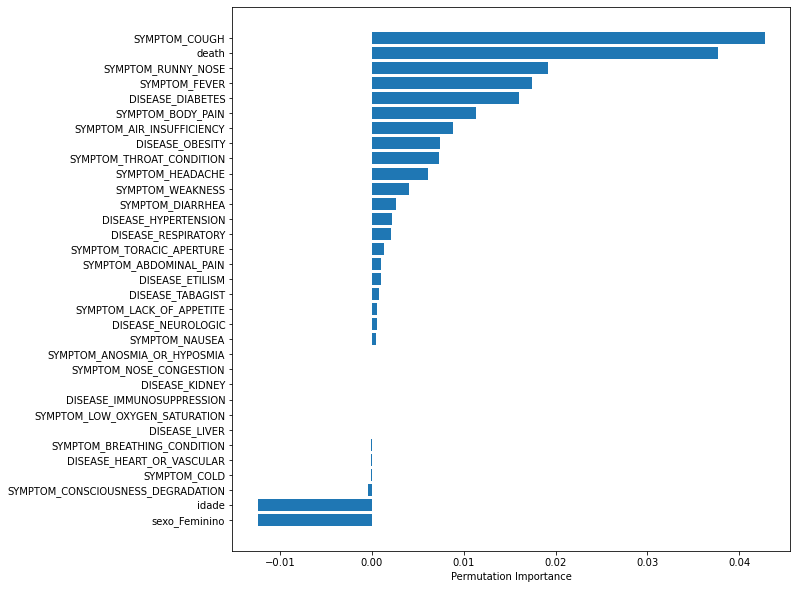

Início do período:  2020-12-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.7938573949523474
best_params_: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.7209864603481625
########################################
"""Métricas f1_score:"""
f1:  0.5945186226282502
Macro:  0.6909194661242983
Micro:  0.7209864603481626
weighted:  0.7247623154367409
########################################
"""Métricas precision_score:"""
Precision:  0.5625
Macro:  0.687025075987842
Micro:  0.7209864603481625
weighted:  0.7307413260686801


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


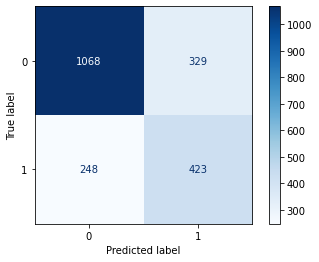

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1397
           1       0.56      0.63      0.59       671

    accuracy                           0.72      2068
   macro avg       0.69      0.70      0.69      2068
weighted avg       0.73      0.72      0.72      2068

roc_auc_score:  0.6974488658366288


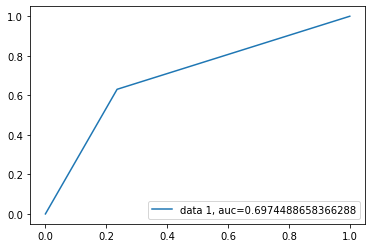

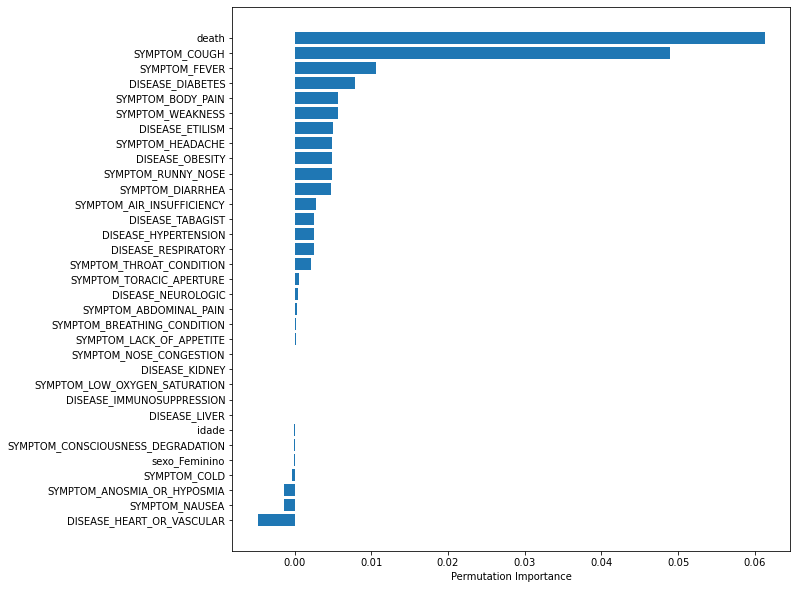

Início do período:  2021-01-21 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.8189488548210353
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6659939455095862
########################################
"""Métricas f1_score:"""
f1:  0.46983449012279765
Macro:  0.6130169258863436
Micro:  0.6659939455095862
weighted:  0.6631524508207033
########################################
"""Métricas precision_score:"""
Precision:  0.48511576626240355
Macro:  0.6152587543799917
Micro:  0.6659939455095862
weighted:  0.6608284989579969


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


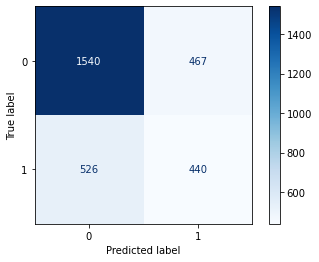

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      2007
           1       0.49      0.46      0.47       966

    accuracy                           0.67      2973
   macro avg       0.62      0.61      0.61      2973
weighted avg       0.66      0.67      0.66      2973

roc_auc_score:  0.6114004710222297


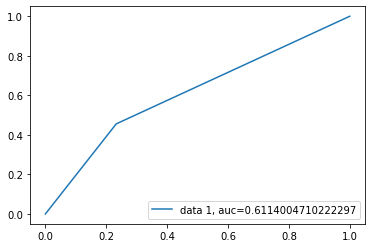

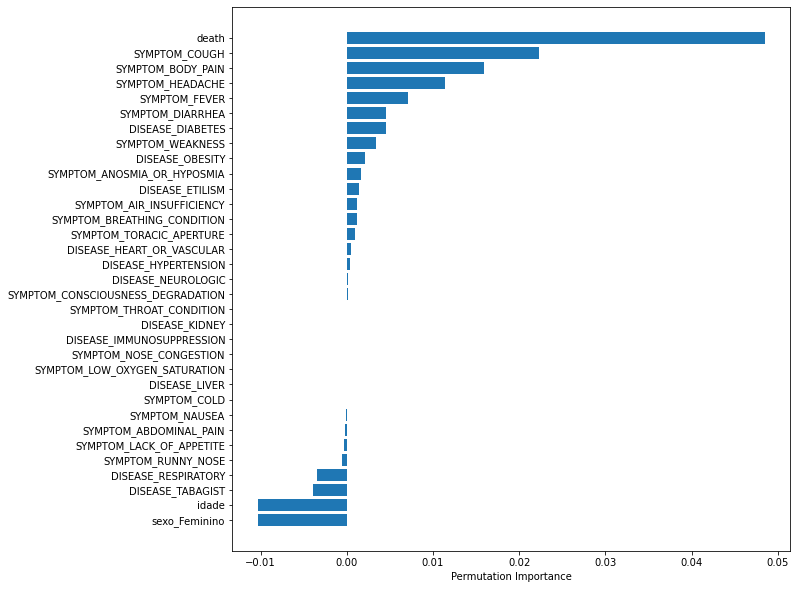

Início do período:  2021-02-20 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8112430210498809
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6872613675807011
########################################
"""Métricas f1_score:"""
f1:  0.5290120230005227
Macro:  0.6474626236073022
Micro:  0.6872613675807011
weighted:  0.690756091999853
########################################
"""Métricas precision_score:"""
Precision:  0.5065065065065065
Macro:  0.6448579291299801
Micro:  0.6872613675807011
weighted:  0.6954251099777822


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


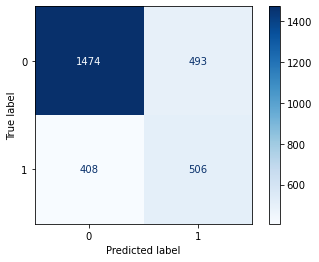

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1967
           1       0.51      0.55      0.53       914

    accuracy                           0.69      2881
   macro avg       0.64      0.65      0.65      2881
weighted avg       0.70      0.69      0.69      2881

roc_auc_score:  0.6514875088856728


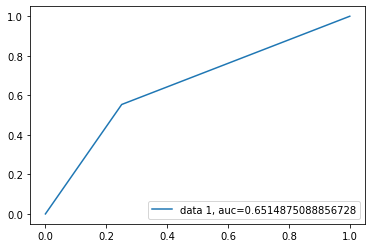

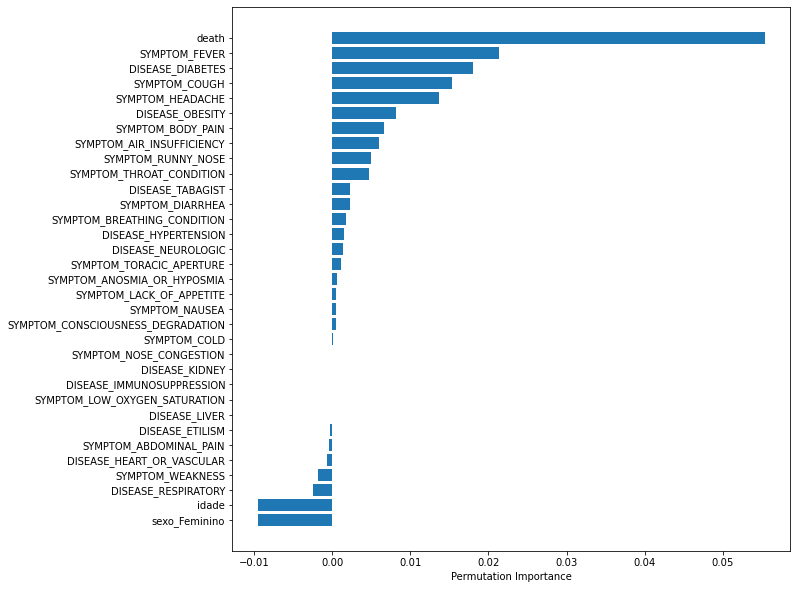

Início do período:  2021-03-22 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.7985048278108733
best_params_: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6963890935887989
########################################
"""Métricas f1_score:"""
f1:  0.5574650912996778
Macro:  0.663196931516356
Micro:  0.6963890935887989
weighted:  0.7081543904736317
########################################
"""Métricas precision_score:"""
Precision:  0.47966728280961185
Macro:  0.6598704061106883
Micro:  0.6963890935887989
weighted:  0.7364932522011238


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


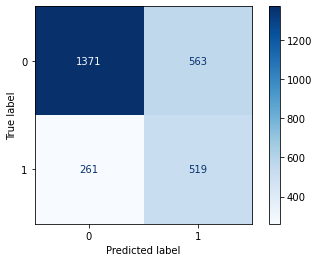

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1934
           1       0.48      0.67      0.56       780

    accuracy                           0.70      2714
   macro avg       0.66      0.69      0.66      2714
weighted avg       0.74      0.70      0.71      2714

roc_auc_score:  0.687139050194893


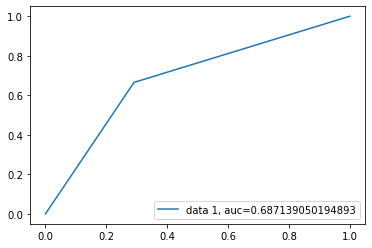

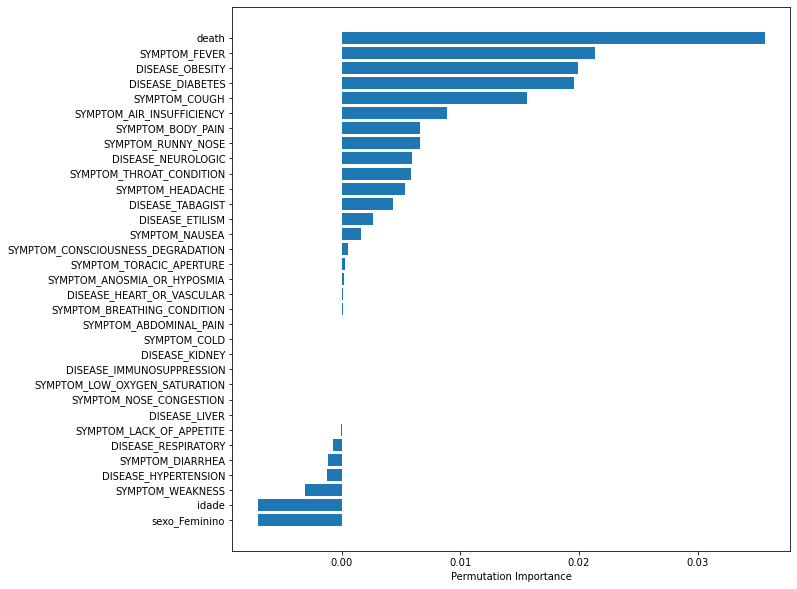

Início do período:  2021-04-21 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.8262928582118038
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.7
########################################
"""Métricas f1_score:"""
f1:  0.49086161879895557
Macro:  0.6391058366622914
Micro:  0.7
weighted:  0.7025087483023026
########################################
"""Métricas precision_score:"""
Precision:  0.47715736040609136
Macro:  0.637033426339911
Micro:  0.7
weighted:  0.7054111899239138


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


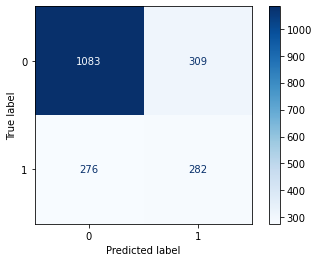

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1392
           1       0.48      0.51      0.49       558

    accuracy                           0.70      1950
   macro avg       0.64      0.64      0.64      1950
weighted avg       0.71      0.70      0.70      1950

roc_auc_score:  0.6416967927326659


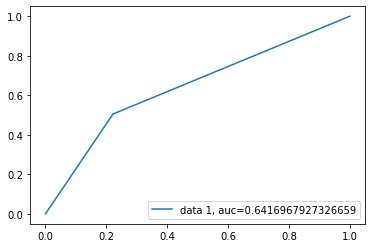

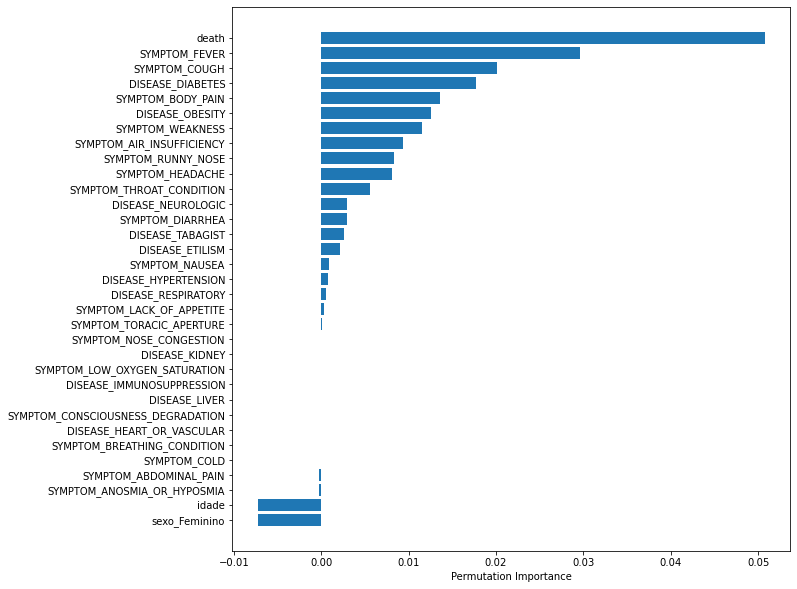

Início do período:  2021-05-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.837874357760952
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6812816188870152
########################################
"""Métricas f1_score:"""
f1:  0.5573770491803278
Macro:  0.6541825957364089
Micro:  0.6812816188870152
weighted:  0.685199549944934
########################################
"""Métricas precision_score:"""
Precision:  0.5277161862527716
Macro:  0.6516131951672022
Micro:  0.6812816188870152
weighted:  0.6913103818345575


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


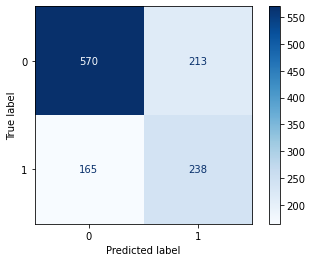

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       783
           1       0.53      0.59      0.56       403

    accuracy                           0.68      1186
   macro avg       0.65      0.66      0.65      1186
weighted avg       0.69      0.68      0.69      1186

roc_auc_score:  0.6592700341309907


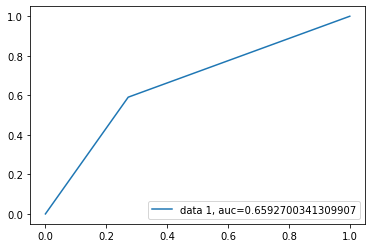

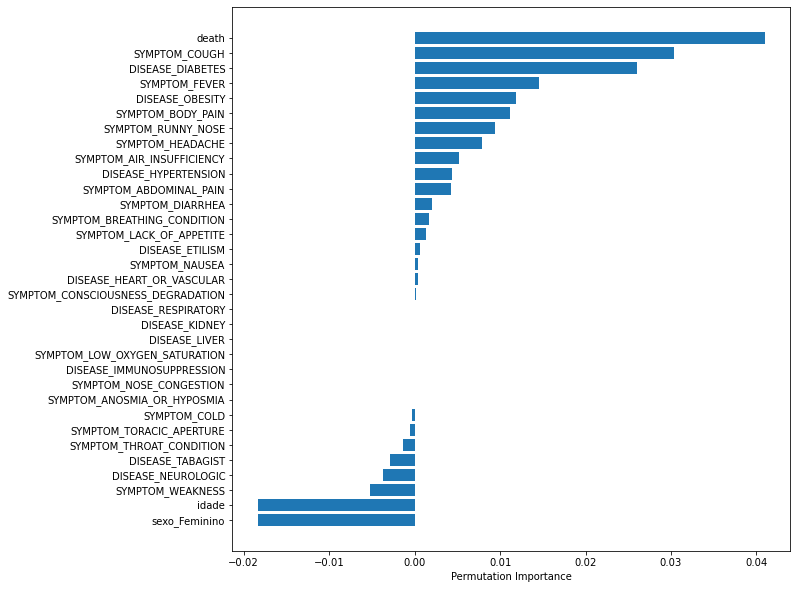

Início do período:  2021-06-20 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.8043027483885028
best_params_: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6513317191283293
########################################
"""Métricas f1_score:"""
f1:  0.5278688524590164
Macro:  0.6257386488782606
Micro:  0.6513317191283293
weighted:  0.6646021999987353
########################################
"""Métricas precision_score:"""
Precision:  0.44598337950138506
Macro:  0.628368033836714
Micro:  0.6513317191283293
weighted:  0.7007919643718082


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


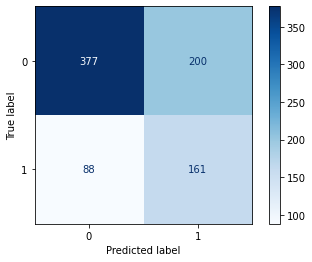

              precision    recall  f1-score   support

           0       0.81      0.65      0.72       577
           1       0.45      0.65      0.53       249

    accuracy                           0.65       826
   macro avg       0.63      0.65      0.63       826
weighted avg       0.70      0.65      0.66       826

roc_auc_score:  0.6499829473874702


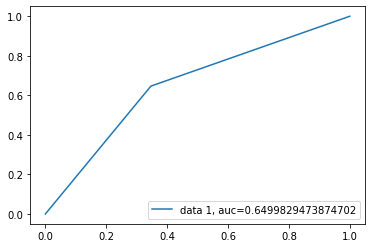

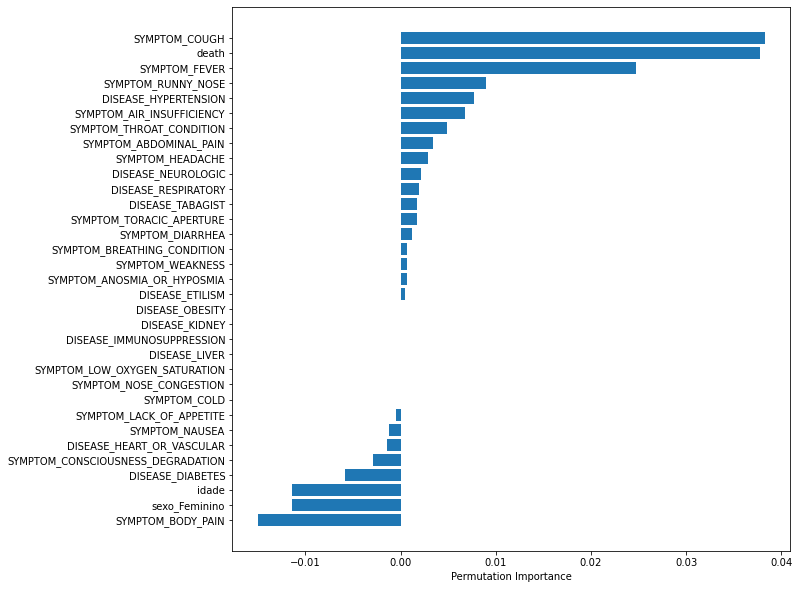

Início do período:  2021-07-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.8498172619617606
best_params_: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6157253599114064
########################################
"""Métricas f1_score:"""
f1:  0.48439821693907875
Macro:  0.5890658339770416
Micro:  0.6157253599114064
weighted:  0.6380961794998083
########################################
"""Métricas precision_score:"""
Precision:  0.37644341801385683
Macro:  0.6063068153899072
Micro:  0.6157253599114064
weighted:  0.7139836892438045


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


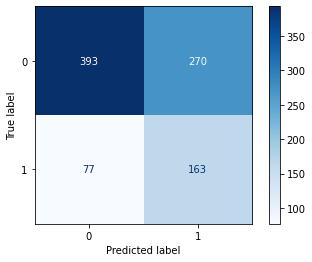

              precision    recall  f1-score   support

           0       0.84      0.59      0.69       663
           1       0.38      0.68      0.48       240

    accuracy                           0.62       903
   macro avg       0.61      0.64      0.59       903
weighted avg       0.71      0.62      0.64       903

roc_auc_score:  0.635963423831071


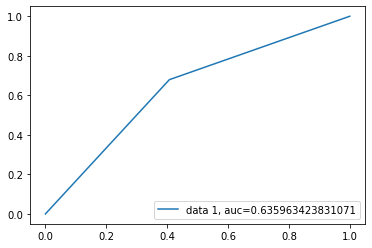

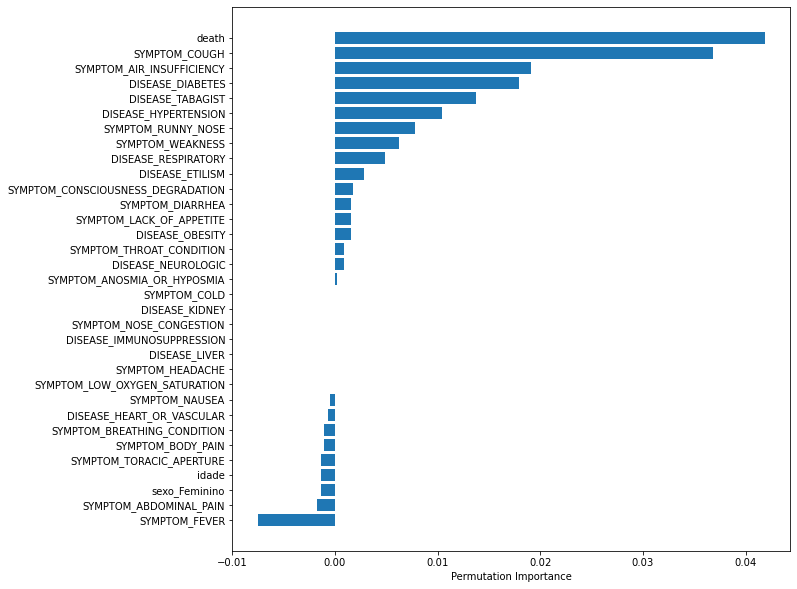

Início do período:  2021-08-19 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.825518798828125
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6513157894736842
########################################
"""Métricas f1_score:"""
f1:  0.3851508120649652
Macro:  0.5709041479975882
Micro:  0.6513157894736842
weighted:  0.670624359919312
########################################
"""Métricas precision_score:"""
Precision:  0.3254901960784314
Macro:  0.5706658901184236
Micro:  0.6513157894736842
weighted:  0.7022865258662089


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


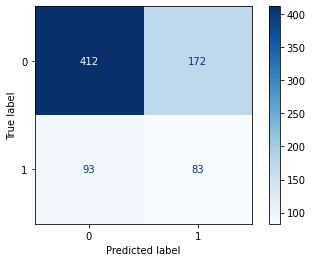

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       584
           1       0.33      0.47      0.39       176

    accuracy                           0.65       760
   macro avg       0.57      0.59      0.57       760
weighted avg       0.70      0.65      0.67       760

roc_auc_score:  0.5885351805728518


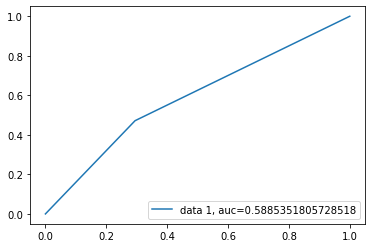

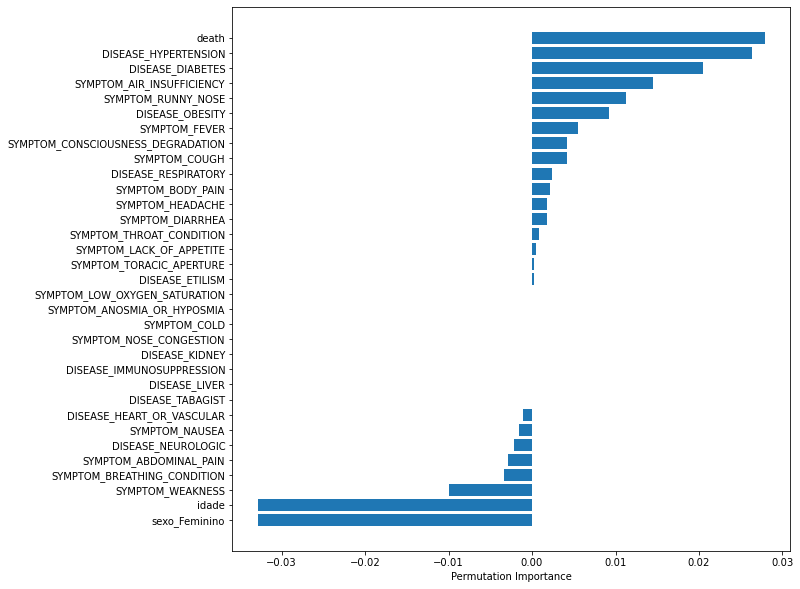

Início do período:  2021-09-18 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.8191098573459932
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.5986394557823129
########################################
"""Métricas f1_score:"""
f1:  0.31870669745958435
Macro:  0.5171161259718365
Micro:  0.5986394557823129
weighted:  0.6296831078624612
########################################
"""Métricas precision_score:"""
Precision:  0.2518248175182482
Macro:  0.5282985258957835
Micro:  0.5986394557823129
weighted:  0.6851550379956913


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


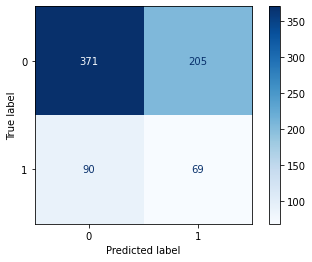

              precision    recall  f1-score   support

           0       0.80      0.64      0.72       576
           1       0.25      0.43      0.32       159

    accuracy                           0.60       735
   macro avg       0.53      0.54      0.52       735
weighted avg       0.69      0.60      0.63       735

roc_auc_score:  0.5390297431865828


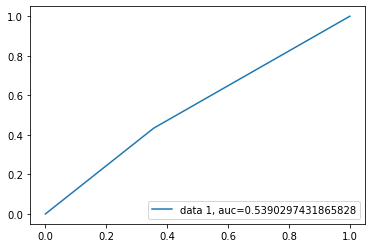

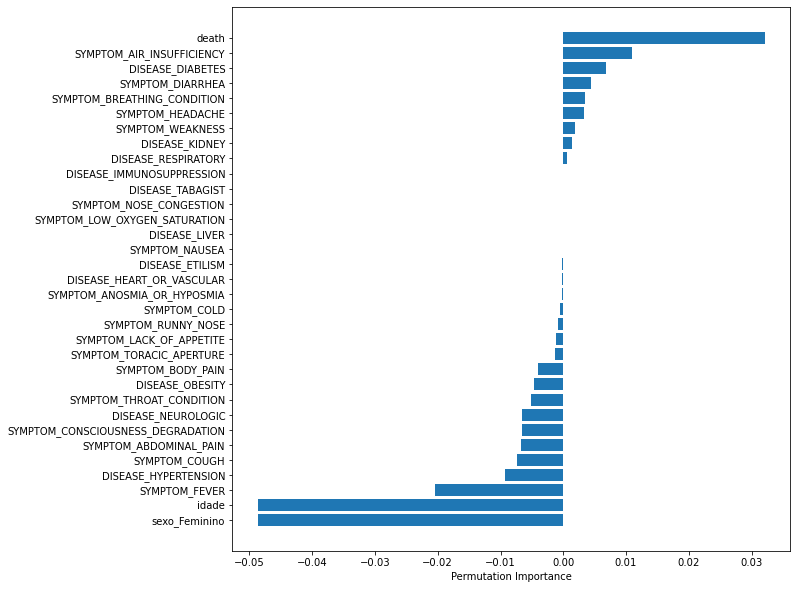

Início do período:  2021-10-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.866260041623309
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6027759418374091
########################################
"""Métricas f1_score:"""
f1:  0.3269876819708846
Macro:  0.5226124532686116
Micro:  0.6027759418374091
weighted:  0.627212876255962
########################################
"""Métricas precision_score:"""
Precision:  0.2698706099815157
Macro:  0.5289682268014575
Micro:  0.6027759418374091
weighted:  0.6675075341427217


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


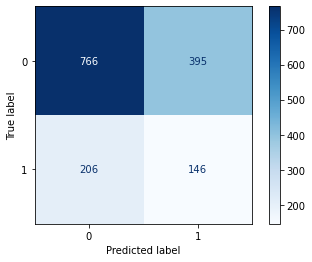

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1161
           1       0.27      0.41      0.33       352

    accuracy                           0.60      1513
   macro avg       0.53      0.54      0.52      1513
weighted avg       0.67      0.60      0.63      1513

roc_auc_score:  0.5372743911988098


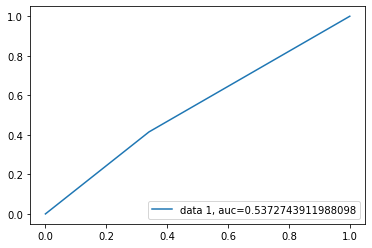

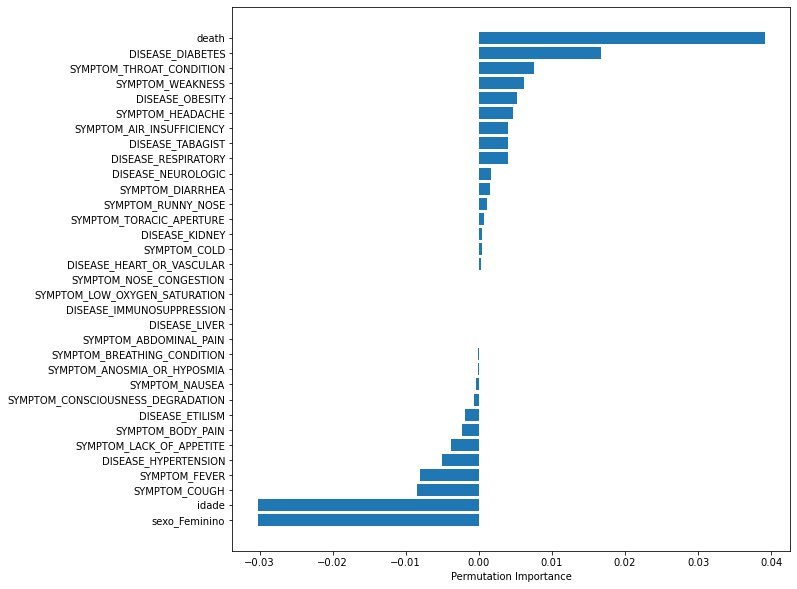

Início do período:  2021-11-17 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.822836885114565
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6441988950276243
########################################
"""Métricas f1_score:"""
f1:  0.3163481953290871
Macro:  0.5379351133478893
Micro:  0.6441988950276243
weighted:  0.6505649280314795
########################################
"""Métricas precision_score:"""
Precision:  0.29979879275653926
Macro:  0.5371804321741569
Micro:  0.6441988950276243
weighted:  0.6578385030383603


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


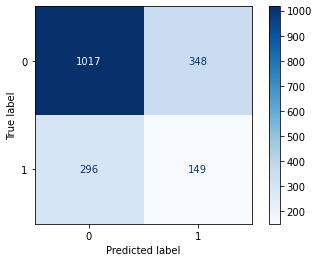

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1365
           1       0.30      0.33      0.32       445

    accuracy                           0.64      1810
   macro avg       0.54      0.54      0.54      1810
weighted avg       0.66      0.64      0.65      1810

roc_auc_score:  0.5399432028645512


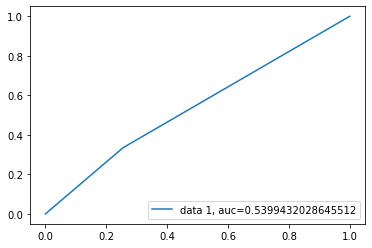

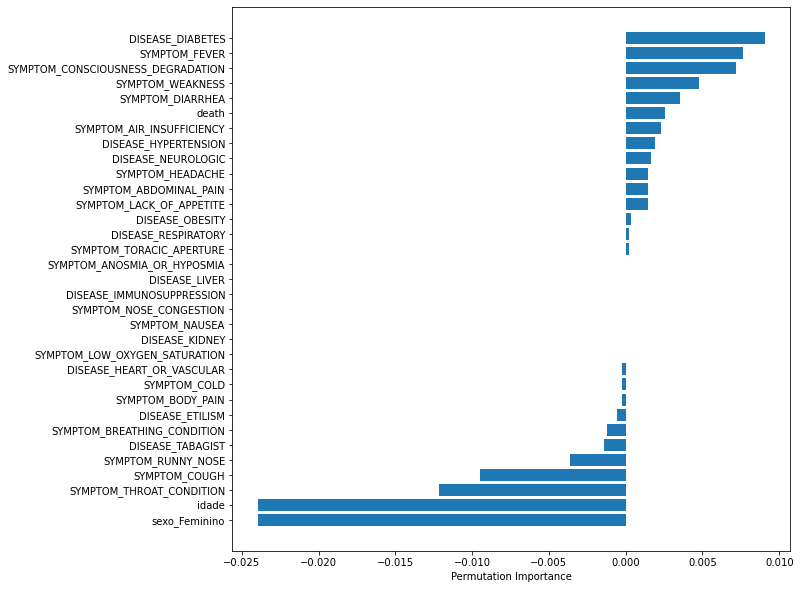

Início do período:  2021-12-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.7905389205604987
best_params_: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.5975836431226765
########################################
"""Métricas f1_score:"""
f1:  0.37337192474674386
Macro:  0.5384997885198469
Micro:  0.5975836431226765
weighted:  0.6044895482061242
########################################
"""Métricas precision_score:"""
Precision:  0.35054347826086957
Macro:  0.5382660894129206
Micro:  0.5975836431226765
weighted:  0.6132853485164355


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


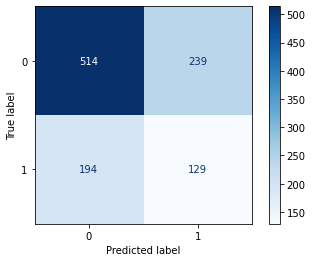

              precision    recall  f1-score   support

           0       0.73      0.68      0.70       753
           1       0.35      0.40      0.37       323

    accuracy                           0.60      1076
   macro avg       0.54      0.54      0.54      1076
weighted avg       0.61      0.60      0.60      1076

roc_auc_score:  0.5409918633001534


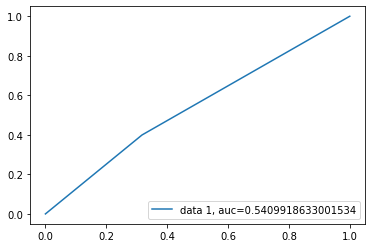

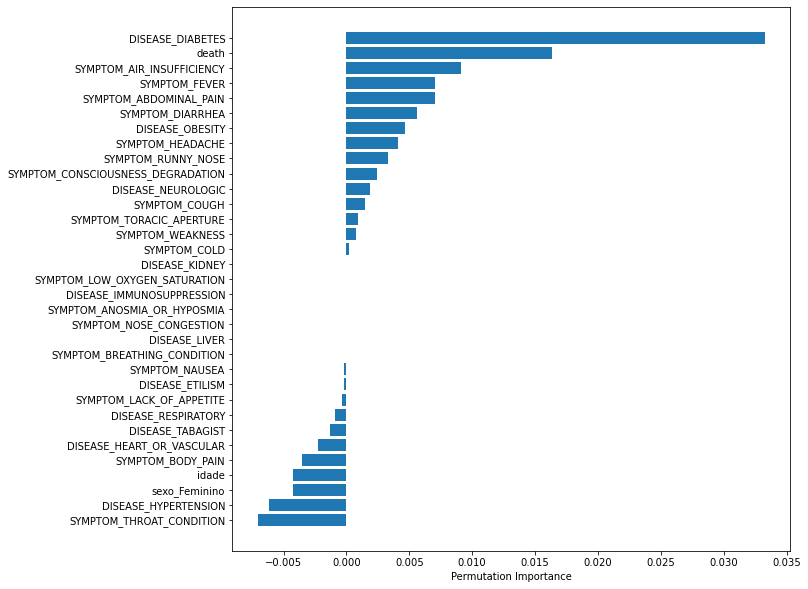

Início do período:  2022-01-16 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.7801241787596563
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6465408805031446
########################################
"""Métricas f1_score:"""
f1:  0.43232323232323233
Macro:  0.5878511138785112
Micro:  0.6465408805031446
weighted:  0.6263907272953537
########################################
"""Métricas precision_score:"""
Precision:  0.5459183673469388
Macro:  0.6126920718203809
Micro:  0.6465408805031446
weighted:  0.6292385117968187


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


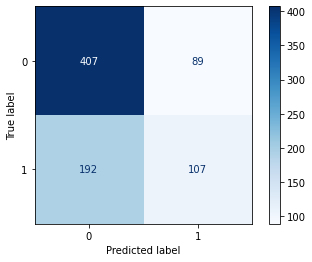

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       496
           1       0.55      0.36      0.43       299

    accuracy                           0.65       795
   macro avg       0.61      0.59      0.59       795
weighted avg       0.63      0.65      0.63       795

roc_auc_score:  0.5892120239508037


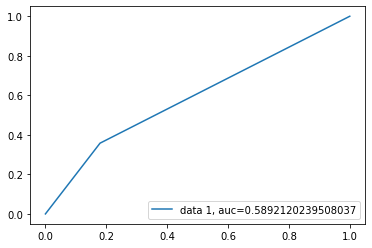

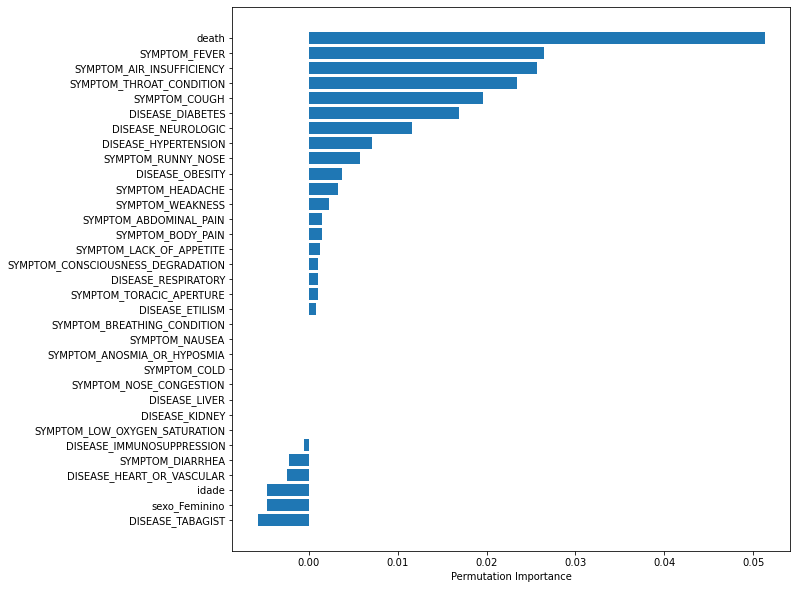

Início do período:  2022-02-15 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.7670027788291391
best_params_: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.6850507982583455
########################################
"""Métricas f1_score:"""
f1:  0.510158013544018
Macro:  0.6390362260233459
Micro:  0.6850507982583455
weighted:  0.6901011781377965
########################################
"""Métricas precision_score:"""
Precision:  0.4808510638297872
Macro:  0.6357999812541006
Micro:  0.6850507982583455
weighted:  0.6971948353278853


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


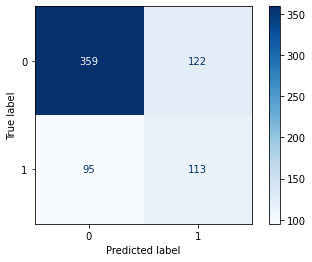

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       481
           1       0.48      0.54      0.51       208

    accuracy                           0.69       689
   macro avg       0.64      0.64      0.64       689
weighted avg       0.70      0.69      0.69       689

roc_auc_score:  0.6448154885654885


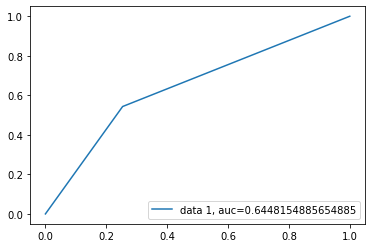

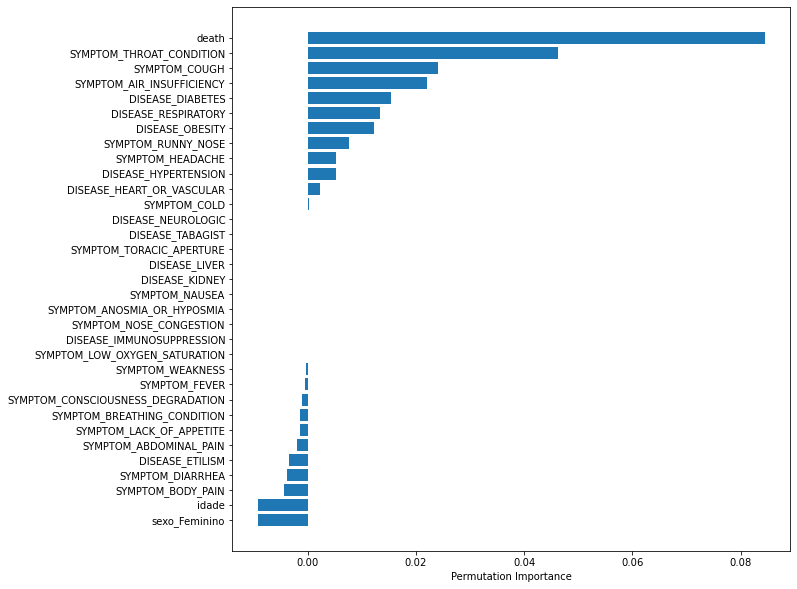

Início do período:  2022-03-17 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8212278735323595
best_params_: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.7140600315955766
########################################
"""Métricas f1_score:"""
f1:  0.36042402826855124
Macro:  0.5881469073184058
Micro:  0.7140600315955766
weighted:  0.7698215580611807
########################################
"""Métricas precision_score:"""
Precision:  0.2328767123287671
Macro:  0.6007378730725961
Micro:  0.7140600315955766
weighted:  0.8942132066833918


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


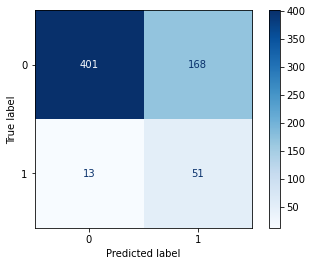

              precision    recall  f1-score   support

           0       0.97      0.70      0.82       569
           1       0.23      0.80      0.36        64

    accuracy                           0.71       633
   macro avg       0.60      0.75      0.59       633
weighted avg       0.89      0.71      0.77       633

roc_auc_score:  0.7508100834797891


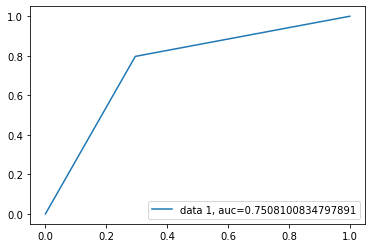

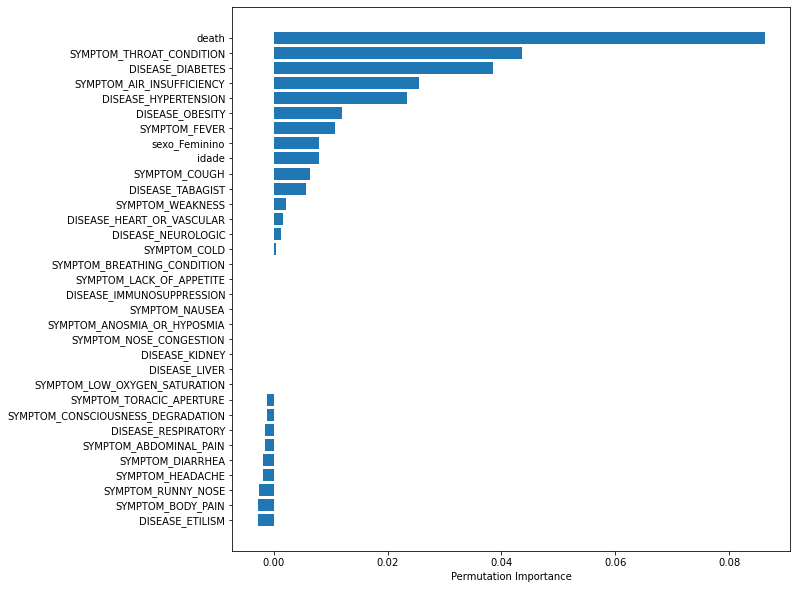

Início do período:  2022-04-16 00:00:00
Final do período:  2022-07-15 00:00:00
########################################

best_score: 0.8985235718343827
best_params_: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
########################################

accuracy_score: 0.7783251231527094
########################################
"""Métricas f1_score:"""
f1:  0.2105263157894737
Macro:  0.5407932438546222
Micro:  0.7783251231527094
weighted:  0.8255061128763019
########################################
"""Métricas precision_score:"""
Precision:  0.13953488372093023
Macro:  0.5447674418604651
Micro:  0.7783251231527094
weighted:  0.8941058540497193


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


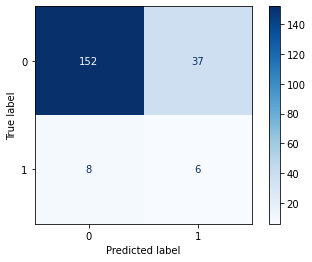

              precision    recall  f1-score   support

           0       0.95      0.80      0.87       189
           1       0.14      0.43      0.21        14

    accuracy                           0.78       203
   macro avg       0.54      0.62      0.54       203
weighted avg       0.89      0.78      0.83       203

roc_auc_score:  0.6164021164021164


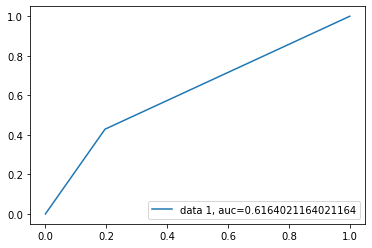

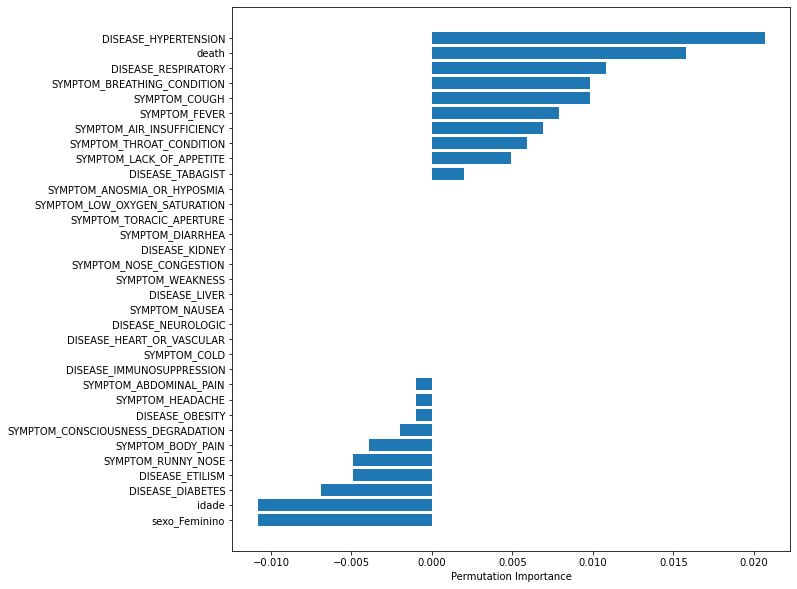

Início do período:  2022-05-16 00:00:00
Final do período:  2022-08-14 00:00:00
########################################

best_score: 0.9676020408163264
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
########################################



ValueError: Found array with 0 sample(s) (shape=(0, 33)) while a minimum of 1 is required by SVC.

In [9]:
apply_periodos(90, df)